In [1]:
# General Libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# TensorFlow and Keras Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, SimpleRNN, LSTM, GRU, Input,
    MultiHeadAttention, LayerNormalization,
    GlobalAveragePooling1D, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Scikit-Learn Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error



# Load the dataset with appropriate column separation and header handling
data = pd.read_csv(
    'datasets\Normalized_WT5.txt', 
    sep=r'\s+',  # Space-separated values, handles multiple spaces as well
    header=0,    # Assumes first row is the header
    index_col=0  # Sequence No. as index
)



In [ ]:
# Implementation of the Huber loss function
def huber_loss(y_true, y_pred, delta=1.0):
    """
    Calculates the Huber loss between true and predicted values.

    Parameters:
    - y_true: numpy array of true values
    - y_pred: numpy array of predicted values
    - delta: threshold at which Huber loss transitions from quadratic to linear

    Returns:
    - Huber loss value
    """
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta

    squared_loss = 0.5 * error**2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)

    return np.where(is_small_error, squared_loss, linear_loss).mean()


                     V         D  air density   Humidity         I       S_a  \
Sequence No.                                                                   
1             6.873766  174.0575     1.219331  50.082808  0.021919  0.110258   
2             7.096613  176.4439     1.219144  48.541693  0.037737  0.061554   
3             8.101572  176.3133     1.218397  46.252931  0.049063  0.152517   
4             8.762237  181.0317     1.219514  47.099364  0.094166  0.254332   
5             9.901171  183.5434     1.216877  44.129409  0.027735  0.073538   

                   S_b  y (% relative to rated power)  
Sequence No.                                           
1             0.135261                      11.653333  
2             0.156136                      30.550000  
3             0.223355                      43.850000  
4             0.256441                      51.660000  
5             0.311642                      46.406667  
<class 'pandas.core.frame.DataFrame'>
Int64Inde

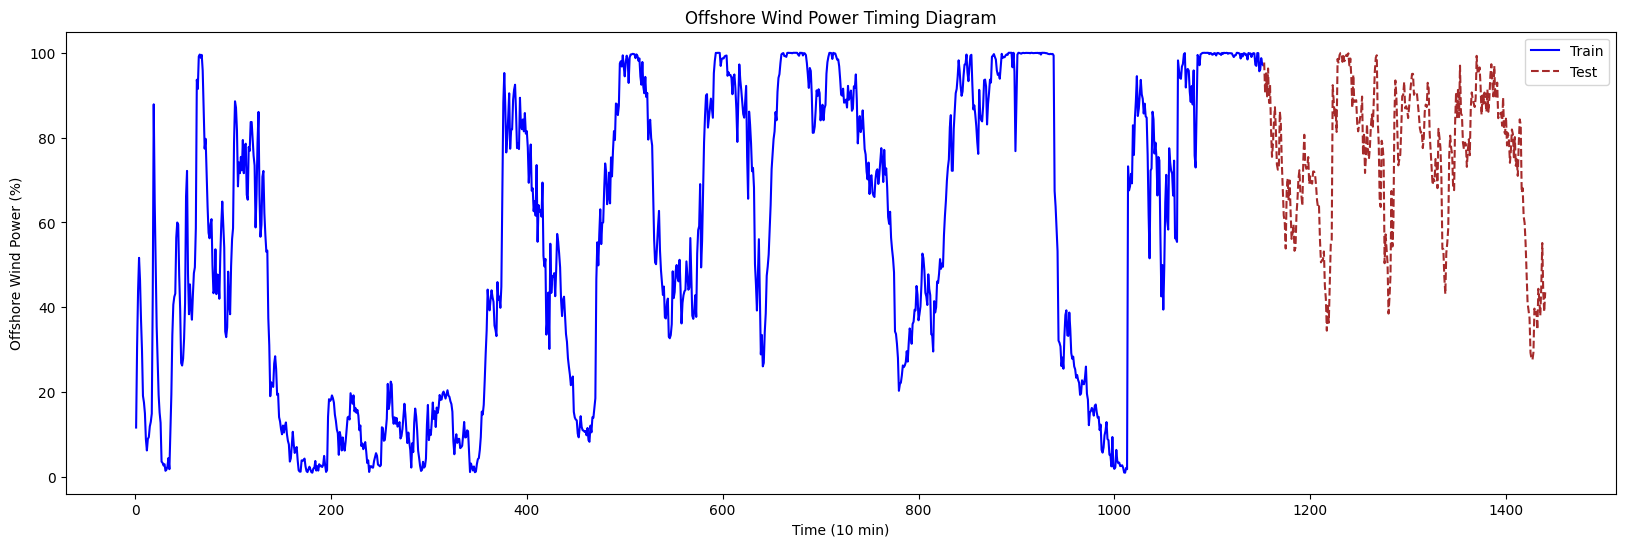

In [2]:

# Display the first few rows for verification
print(data.head())

# Verify data types
print(data.info())

# Generate the timing diagram for the target variable 'y (% relative to rated power)'
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

plt.figure(figsize=(20, 6))
plt.plot(train_data.index, train_data['y (% relative to rated power)'], label='Train', color='blue')
plt.plot(test_data.index, test_data['y (% relative to rated power)'], label='Test', color='brown', linestyle='dashed')
plt.xlabel('Time (10 min)')
plt.ylabel('Offshore Wind Power (%)')
plt.title('Offshore Wind Power Timing Diagram')
plt.legend()
plt.show()


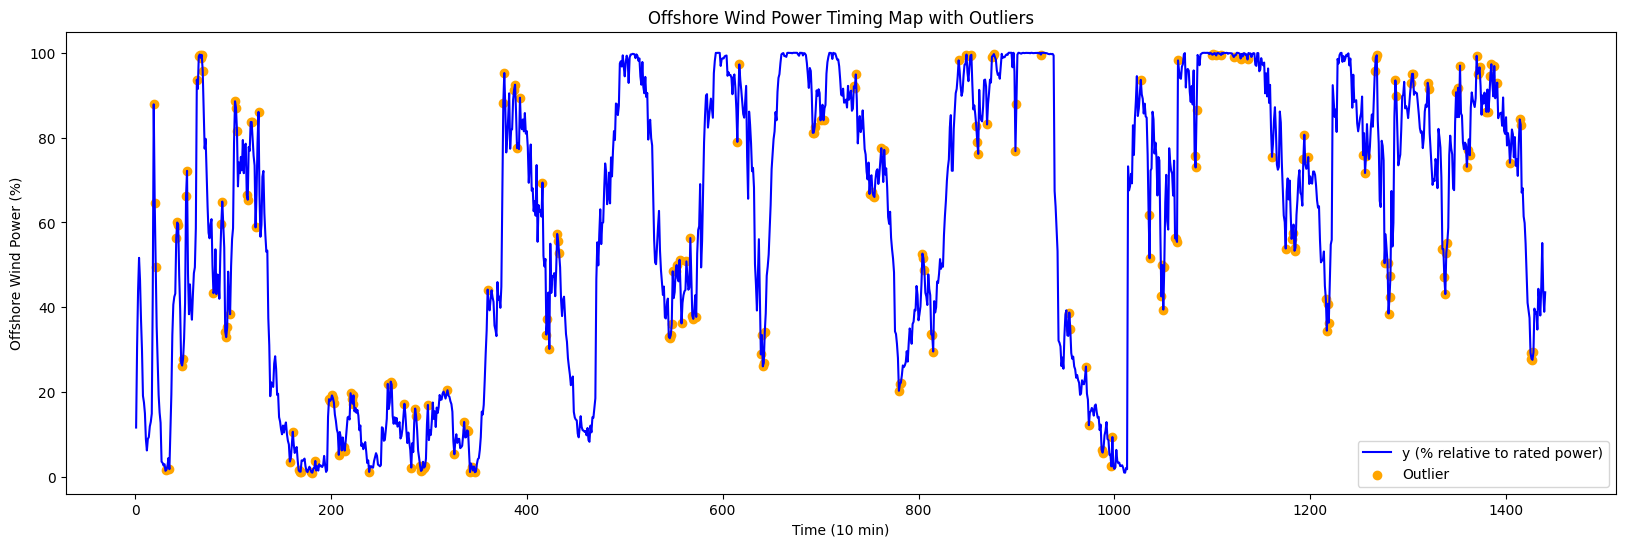

In [3]:
# Define window size and threshold
window_size = 24
threshold_factor = 1

# Calculate rolling mean and standard deviation
rolling_mean = data['y (% relative to rated power)'].rolling(window=window_size, center=True).mean()
rolling_std = data['y (% relative to rated power)'].rolling(window=window_size, center=True).std()

# Identify outliers
outliers = (data['y (% relative to rated power)'] > rolling_mean + threshold_factor * rolling_std) | \
           (data['y (% relative to rated power)'] < rolling_mean - threshold_factor * rolling_std)

# Plot with outliers
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['y (% relative to rated power)'], label='y (% relative to rated power)', color='blue')
plt.scatter(data.index[outliers], data['y (% relative to rated power)'][outliers], label='Outlier', color='orange')
plt.xlabel('Time (10 min)')
plt.ylabel('Offshore Wind Power (%)')
plt.title('Offshore Wind Power Timing Map with Outliers')
plt.legend()
plt.show()


In [4]:
# Check for missing values
print(data.isnull().sum())

data.fillna(data.mean(), inplace=True)

# Adding a simple lag feature (previous time step values)
for col in data.columns:
    data[f'{col}_lag1'] = data[col].shift(1)

# Drop rows with NaN created due to shifting
data.dropna(inplace=True)


V                                0
D                                0
air density                      0
Humidity                         0
I                                0
S_a                              0
S_b                              0
y (% relative to rated power)    0
dtype: int64


In [5]:
# Select the feature columns
feature_columns = ['V', 'D', 'air density', 'Humidity', 'I', 'S_a', 'S_b', 'y (% relative to rated power)']

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[feature_columns])

# Create a DataFrame for the scaled data
scaled_data = pd.DataFrame(scaled_data, columns=feature_columns)


45/45 [==============================] - 0s 2ms/step


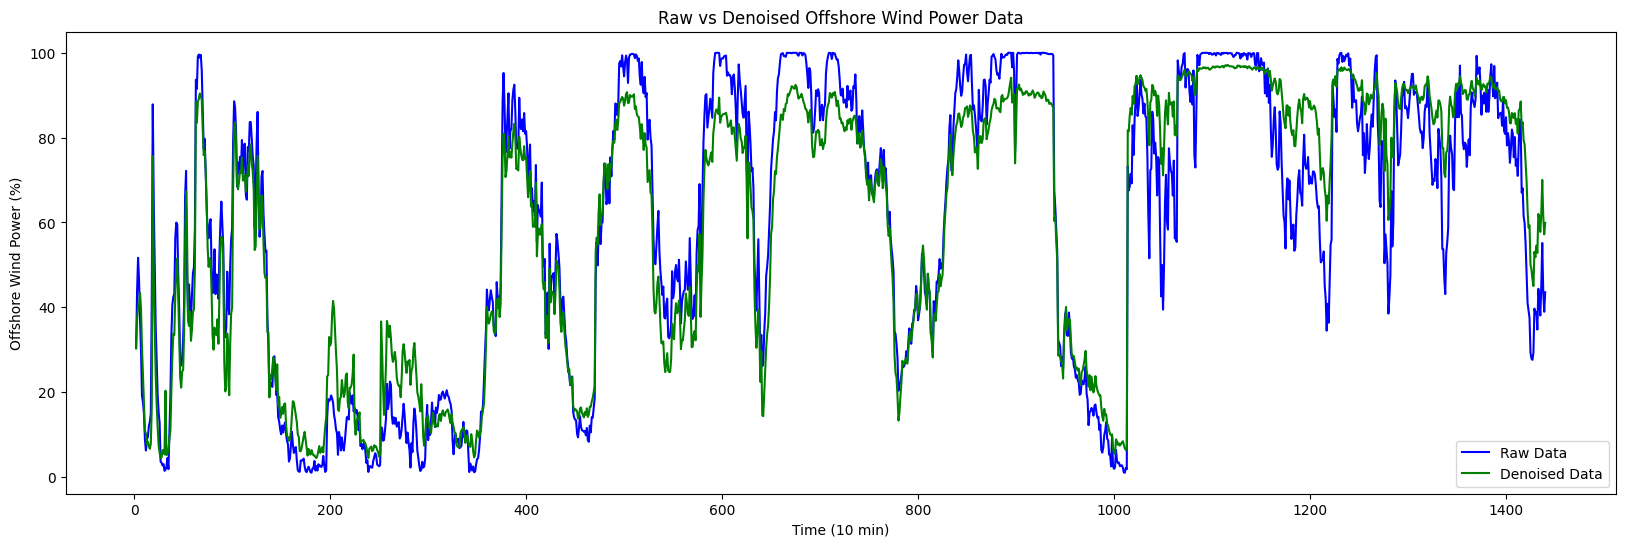

In [26]:
# Build the Autoencoder
def build_autoencoder(input_dim, latent_dim):
    """
    Build a simple Autoencoder.
    - input_dim: Number of input features.
    - latent_dim: Size of the latent (compressed) representation.
    """
    input_layer = Input(shape=(input_dim,))
    latent_layer = Dense(latent_dim, activation='relu')(input_layer)
    output_layer = Dense(input_dim, activation='sigmoid')(latent_layer)
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return autoencoder

# Set input_dim to the number of features in the dataset
input_dim = scaled_data.shape[1]
latent_dim = 2
autoencoder = build_autoencoder(input_dim=input_dim, latent_dim=latent_dim)

# Train the Autoencoder
autoencoder.fit(scaled_data, scaled_data, epochs=60, batch_size=8, verbose=0)

# Denoise data
denoised_data = autoencoder.predict(scaled_data)
denoised_data_ = scaler.inverse_transform(denoised_data)

# Plot raw vs denoised data for the target variable
plt.figure(figsize=(20, 6))
plt.plot(data.index, data['y (% relative to rated power)'], label='Raw Data', color='blue')
plt.plot(data.index, denoised_data_[:, -1], label='Denoised Data', color='green')  # Use the last column (target variable)
plt.xlabel('Time (10 min)')
plt.ylabel('Offshore Wind Power (%)')
plt.title('Raw vs Denoised Offshore Wind Power Data')
plt.legend()
plt.show()


In [27]:
def prepare_sliding_window(data, window_size=144, target_steps=24, multi_step=True):
    """
    Prepares data for sliding window approach.
    """
    X, Y = [], []
    for i in range(len(data) - window_size - target_steps + 1):
        X.append(data[i:i+window_size])  # Input sequence
        if multi_step:
            Y.append(data[i+window_size:i+window_size+target_steps])  # Multi-step
        else:
            Y.append(data[i+window_size+target_steps-1])  # Single-step
    return np.array(X), np.array(Y)

denoised_data = pd.DataFrame(denoised_data, columns=feature_columns)

print(denoised_data.isnull().sum())
denoised_data.dropna(inplace=True)


V                                0
D                                0
air density                      0
Humidity                         0
I                                0
S_a                              0
S_b                              0
y (% relative to rated power)    0
dtype: int64


In [28]:
# Prepare data for multi-step prediction
X, Y = prepare_sliding_window(denoised_data.values, window_size=144, target_steps=24, multi_step=False)
Y = Y[:, -1] * 100


# Reshape X for MLP model (flatten time steps and features)
X_mlp = X.reshape(X.shape[0], -1)

# Split into training and testing sets
train_size = int(0.80 * len(X_mlp))
X_train_mlp, Y_train = X_mlp[:train_size], Y[:train_size]
X_test_mlp, Y_test = X_mlp[train_size:], Y[train_size:]

# Print shapes to verify
print("X_train shape:", X_train_mlp.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test_mlp.shape)
print("Y_test shape:", Y_test.shape)



X_train shape: (1017, 1152)
Y_train shape: (1017,)
X_test shape: (255, 1152)
Y_test shape: (255,)


In [30]:
def prepare_sliding_window(data, window_size=144, target_steps=24, multi_step=True):
    """
    Prepares data for sliding window approach.
    """
    X, Y = [], []
    for i in range(len(data) - window_size - target_steps + 1):
        X.append(data[i:i+window_size])  # Input sequence
        if multi_step:
            Y.append(data[i+window_size:i+window_size+target_steps])  # Multi-step
        else:
            Y.append(data[i+window_size+target_steps-1])  # Single-step
    return np.array(X), np.array(Y)

X, Y = prepare_sliding_window(denoised_data.values, window_size=144, target_steps=24, multi_step=False)
Y = Y[:, -1] * 100

# Split into training and testing sets
train_size = int(0.80 * len(X_mlp))
X_train_transformer, Y_train = X[:train_size], Y[:train_size]
X_test_transformer, Y_test = X[train_size:], Y[train_size:]


In [33]:
def build_mlp(input_dim, output_steps, loss: str, multi_step=True):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(output_steps)  # For multi-step, this will output multiple values
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=loss)
    return model

def build_rnn(input_dim, output_steps, loss: str, multi_step=True):
    model = Sequential([
        SimpleRNN(64, activation='relu', input_shape=(input_dim, 8)),  # Adjust input shape if necessary
        Dense(32, activation='relu'),
        Dense(output_steps)  # For multi-step, this will output multiple values
    ])
    model.compile(optimizer=Adam(learning_rate=0.005), loss=loss)
    return model

def build_transformer(input_dim, output_steps, loss: str, multi_step=True, d_model=32, num_heads=2, num_layers=2, dropout_rate=0.1):
    inputs = Input(shape=(input_dim, 8))
    x = Dense(d_model)(inputs)

    for _ in range(num_layers):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        ffn_output = Dense(d_model, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(output_steps)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.01), loss=loss)
    return model

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mae, rmse, mape

def train_and_evaluate(X_train, Y_train, X_test, Y_test, build_model_fn, loss, model_name, results_df, multi_step=True):
    output_steps = Y_train.shape[1] if multi_step else 1
    model = build_model_fn(X_train.shape[1], output_steps, loss, multi_step)
    early_stopping = EarlyStopping(monitor='loss', patience=2)
    model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=0, callbacks=[early_stopping])
    y_pred = model.predict(X_test)

    if multi_step:
        y_pred = y_pred.reshape(y_pred.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)
    
    mae, rmse, mape = evaluate_model(Y_test, y_pred)
    results_df.loc[model_name, f'{loss}_MAE'] = mae
    results_df.loc[model_name, f'{loss}_RMSE'] = rmse
    results_df.loc[model_name, f'{loss}_MAPE'] = mape

    print(f"{model_name}, Loss: {loss} Results - MAE: {mae}, RMSE: {rmse}, MAPE: {mape}")

# Initialize results DataFrame
results_df = pd.DataFrame()

# Train and evaluate models
# MLP
train_and_evaluate(
    X_train_mlp, Y_train, X_test_mlp, Y_test, 
    build_model_fn=build_mlp, loss='mse', model_name='MLP_single_step', 
    results_df=results_df, multi_step=False
)
train_and_evaluate(
    X_train_mlp, Y_train, X_test_mlp, Y_test, 
    build_model_fn=build_mlp, loss='huber', model_name='MLP_single_step', 
    results_df=results_df, multi_step=False
)

# RNN
# Reshape X for RNN model (keep time steps and features separate)
X_rnn = X.reshape(X.shape[0], X.shape[1], -1)

# Split into training and testing sets for RNN
X_train_rnn, Y_train = X_rnn[:train_size], Y[:train_size]
X_test_rnn, Y_test = X_rnn[train_size:], Y[train_size:]

# Train and evaluate RNN model for single-step prediction
train_and_evaluate(
    X_train_rnn, Y_train, X_test_rnn, Y_test, 
    build_model_fn=build_rnn, loss='mse', model_name='RNN_single_step', 
    results_df=results_df, multi_step=False
)
train_and_evaluate(
    X_train_rnn, Y_train, X_test_rnn, Y_test, 
    build_model_fn=build_rnn, loss='huber', model_name='RNN_single_step', 
    results_df=results_df, multi_step=False
)

# Transformer
# Split into training and testing sets for Transformer
X_train_transformer, Y_train = X[:train_size], Y[:train_size]
X_test_transformer, Y_test = X[train_size:], Y[train_size:]

train_and_evaluate(
    X_train_transformer, Y_train, X_test_transformer, Y_test, 
    build_model_fn=build_transformer, loss='mse', model_name='Transformer_single_step', 
    results_df=results_df, multi_step=False
)
train_and_evaluate(
    X_train_transformer, Y_train, X_test_transformer, Y_test, 
    build_model_fn=build_transformer, loss='huber', model_name='Transformer_single_step', 
    results_df=results_df, multi_step=False
)

# Save the results as a formatted table
results_table = results_df.reset_index()
results_table.rename(columns={'index': 'Model'}, inplace=True)



8/8 [==============================] - 0s 2ms/step
MLP_single_step, Loss: mse Results - MAE: 10.015494346618652, RMSE: 12.385655403137207, MAPE: 0.1299285590648651
8/8 [==============================] - 0s 2ms/step
MLP_single_step, Loss: huber Results - MAE: 16.025184631347656, RMSE: 18.237255096435547, MAPE: 0.1934564858675003
8/8 [==============================] - 0s 13ms/step
RNN_single_step, Loss: mse Results - MAE: 12.823188781738281, RMSE: 14.785517692565918, MAPE: 0.15951475501060486
8/8 [==============================] - 0s 15ms/step
RNN_single_step, Loss: huber Results - MAE: 11.661213874816895, RMSE: 15.101669311523438, MAPE: 0.14662793278694153
8/8 [==============================] - 1s 77ms/step
Transformer_single_step, Loss: mse Results - MAE: 27.963186264038086, RMSE: 29.57526969909668, MAPE: 0.3181445896625519
8/8 [==============================] - 2s 148ms/step
Transformer_single_step, Loss: huber Results - MAE: 17.738916397094727, RMSE: 18.872846603393555, MAPE: 0.20624

In [34]:
# Display the results table in the console
print(results_table)

# Create DataFrame

df_results_table = pd.DataFrame(results_table)



# Reshape the DataFrame to match the table style in the image

reshaped_data = []

metrics = ["MAE", "RMSE", "MAPE"]

loss_types = ["mse", "huber"]



for metric in metrics:

    for i, row in df_results_table.iterrows():

        reshaped_data.append({

            "Index": metric,

            "Model": row["Model"],

            "MSE": row[f"mse_{metric}"],

            "Huber": row[f"huber_{metric}"]

        })



reshaped_df = pd.DataFrame(reshaped_data)

# Or save the results table to a CSV file
results_table.to_csv("model_evaluation_results.csv", index=False)

# Or display it using Pandas directly in Jupyter Notebook
from IPython.display import display
display(reshaped_df)


                     Model    mse_MAE   mse_RMSE  mse_MAPE  huber_MAE  \
0          MLP_single_step  10.015494  12.385655  0.129929  16.025185   
1          RNN_single_step  12.823189  14.785518  0.159515  11.661214   
2  Transformer_single_step  27.963186  29.575270  0.318145  17.738916   

   huber_RMSE  huber_MAPE  
0   18.237255    0.193456  
1   15.101669    0.146628  
2   18.872847    0.206247  


,Index,Model,MSE,Huber
0,MAE,MLP_single_step,10.015494,16.025185
1,MAE,RNN_single_step,12.823189,11.661214
2,MAE,Transformer_single_step,27.963186,17.738916
3,RMSE,MLP_single_step,12.385655,18.237255
4,RMSE,RNN_single_step,14.785518,15.101669
5,RMSE,Transformer_single_step,29.575270,18.872847
6,MAPE,MLP_single_step,0.129929,0.193456
7,MAPE,RNN_single_step,0.159515,0.146628
8,MAPE,Transformer_single_step,0.318145,0.206247


In [40]:
X, Y = prepare_sliding_window(denoised_data.values, window_size=144, target_steps=24, multi_step=True)
Y = Y[:, -1] * 100

# Split into training and testing sets
train_size = int(0.80 * len(X_mlp))
X_train_transformer, Y_train = X[:train_size], Y[:train_size]
print(Y_train.shape, X.shape)
X_test_transformer, Y_test = X[train_size:], Y[train_size:]

# Define objective function to minimize (in this case, MSE)
def objective_function(hyperparameters):
    d_model, num_heads, num_layers, dropout_rate, batch_size, learning_rate, epochs, loss = hyperparameters
    d_model = int(d_model)
    num_heads = int(num_heads)
    num_layers = int(num_layers)
    batch_size = int(batch_size)
    epochs = int(epochs)    

    # Build transformer model with hyperparameters
    model = build_transformer(input_dim=X_train_transformer.shape[1],
                              output_steps = Y_train.shape[1],
                              loss=loss,
                              d_model=d_model, num_heads=num_heads, num_layers=num_layers,
                              dropout_rate=dropout_rate)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

    # Train the model
    model.fit(X_train_transformer, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    # Evaluate model performance
    y_pred = model.predict(X_test_transformer)
    mse = mean_squared_error(Y_test, y_pred)
    return mse

# Slime Mould Optimization (SMO) Algorithm
def slime_mould_optimization():
    # Hyperparameter space boundaries
    param_ranges = {
        'd_model': (16, 64),       # Embedding dimension
        'num_heads': (1, 4),       # Number of attention heads
        'num_layers': (1, 3),       # Number of transformer layers
        'dropout_rate': (0.1, 0.3), # Dropout rate
        'batch_size': (32, 128),     # Batch size
        'learning_rate': (1e-5, 5e-3), # Learning rate
        'epochs': (10, 50),          # Number of epochs
        'loss': ['mse', 'huber']  # Categorical loss options
    }

    # Initialize the slime mould particles (population)
    population_size = 5
    population = []

    for _ in range(population_size):
        individual = []

        # For each parameter, generate a value
        for param in param_ranges:
            if isinstance(param_ranges[param], tuple):  # Continuous range
                individual.append(random.uniform(param_ranges[param][0], param_ranges[param][1]))
            elif isinstance(param_ranges[param], list):  # Categorical list
                individual.append(random.choice(param_ranges[param]))
            elif isinstance(param_range, tuple) and isinstance(param_range[0], int):  # Integer range
                individual.append(random.randint(param_range[0], param_range[1]))

        population.append(individual)

    # Initialize best solution and its corresponding score
    best_solution = None
    best_score = float('inf')

    j = 0
    # SMO main loop
    for generation in tqdm(range(10)):  # Maximum number of generations
        print(j)
        j+=1
        for i, hyperparameters in enumerate(population):
            # Evaluate the objective function
            score = objective_function(hyperparameters)

            # Update best solution if the current one is better
            if score < best_score:
                best_score = score
                best_solution = hyperparameters

        # Update the slime mould population (explore and exploit)
        new_population = []
        for ind_idx in range(population_size):  # Outer loop - over each individual
            # Randomly move slime moulds in the search space
            new_individual = []
            print(f"Individual {ind_idx}: {population[ind_idx]}")
            
            for param_idx, param in enumerate(population[ind_idx]):  # Inner loop - over each parameter in the individual
                param_name = list(param_ranges.keys())[param_idx]  # Get the parameter name (e.g., 'd_model', 'num_heads', etc.)
                
                if isinstance(param_ranges[param_name][0], (int, float)):  # Continuous parameter (int or float)
                    # For continuous parameters (e.g., 'd_model', 'num_heads')
                    new_value = param + random.uniform(-0.05, 0.05) * (param - best_solution[param_idx])
                    new_individual.append(new_value)
                else:  # Categorical parameter (e.g., loss function)
                    # If it's a categorical parameter, pick a new value from the options
                    new_value = random.choice(param_ranges['loss'])  # Pick a new loss function
                    new_individual.append(new_value)

            new_population.append(new_individual)

        population = new_population


        print(f"Generation {generation + 1}, Best Score: {best_score}")

    return best_solution, best_score

# Run the Slime Mould Optimization
best_hyperparameters, best_mse = slime_mould_optimization()

print(f"Best Hyperparameters: {best_hyperparameters}")
print(f"Best MSE: {best_mse}")


(1017, 8) (1272, 144, 8)


  0%|          | 0/10 [00:00<?, ?it/s]

0
8/8 [==============================] - 1s 66ms/step


 10%|█         | 1/10 [11:59<1:47:55, 719.54s/it]

Individual 0: [17.822129029537262, 1.4262113803210554, 2.9814963835161086, 0.21836804527998183, 90.8120711331063, 0.0007714578278087726, 46.44564145657384, 'huber']
Individual 1: [42.50560704605246, 3.4841740718264047, 2.772232895099952, 0.22803368391825943, 93.39720824644853, 0.0015403424102100373, 17.601989001804252, 'mse']
Individual 2: [22.736296358407653, 2.4898181607416228, 2.4779938596079303, 0.2529211378296262, 37.83444339323843, 0.004511786900713305, 43.495831345260285, 'mse']
Individual 3: [32.528993429043325, 2.289105272439109, 1.9945377308927343, 0.14399643734275033, 120.47859833006731, 0.0029571348069115312, 31.774091679940632, 'huber']
Individual 4: [43.52833632894337, 2.4524267638169186, 1.5768858654762963, 0.29722038807344586, 118.51217354587862, 0.002888276961605106, 32.00710635955616, 'mse']
Generation 1, Best Score: 66.36544036865234
1
8/8 [==============================] - 1s 80ms/step


 20%|██        | 2/10 [26:08<1:46:03, 795.42s/it]

Individual 0: [17.679169436042333, 1.4504983834242897, 2.9981300204892114, 0.21739255237092991, 90.18933485188363, 0.0005855397198753477, 46.51787857810345, 'huber']
Individual 1: [42.73340287016761, 3.4601471646342756, 2.775564702546652, 0.2271128086762766, 94.08569181827151, 0.001506104472377641, 17.562382820118852, 'mse']
Individual 2: [22.736296358407653, 2.4898181607416228, 2.4779938596079303, 0.2529211378296262, 37.83444339323843, 0.004511786900713305, 43.495831345260285, 'mse']
Individual 3: [32.80121396588507, 2.2922965495357137, 2.0162561743595577, 0.14076448405805358, 117.87618624542407, 0.002893488789712003, 31.879511958495314, 'mse']
Individual 4: [44.564559867558046, 2.450600930152128, 1.5803746863874706, 0.29583479750653513, 119.58947271551258, 0.0028788767587359467, 31.473391732677676, 'mse']
Generation 2, Best Score: 66.36544036865234
2
8/8 [==============================] - 1s 65ms/step


 30%|███       | 3/10 [42:03<1:41:18, 868.41s/it]

Individual 0: [17.501783954398476, 1.47615585811788, 3.018824662102947, 0.2165070528525926, 88.58045847583298, 0.0004405936913433511, 46.42192063131895, 'huber']
Individual 1: [43.386309613611175, 3.440057521134717, 2.7677174709855388, 0.22730237429102265, 94.87977419850404, 0.0014619393339203725, 16.51785378710659, 'huber']
Individual 2: [22.736296358407653, 2.4898181607416228, 2.4779938596079303, 0.2529211378296262, 37.83444339323843, 0.004511786900713305, 43.495831345260285, 'huber']
Individual 3: [32.68859877270998, 2.297079098044664, 2.012403819778633, 0.14367083784957657, 115.7166152278701, 0.00295479330307468, 31.67043281790212, 'huber']
Individual 4: [45.29856386032622, 2.45128929093327, 1.5766013599370354, 0.2960000406226475, 122.80573360736156, 0.002848777101386906, 31.42350981226125, 'huber']
Generation 3, Best Score: 66.36544036865234
3
8/8 [==============================] - 0s 26ms/step
Individual 0: [17.287553634591116, 1.4544734418883447, 3.0244538886425305, 0.2155128608

 40%|████      | 4/10 [54:52<1:22:55, 829.27s/it]


Individual 1: [43.750958726678014, 3.467620507887269, 2.7598861335979317, 0.22759274224374956, 96.35355259138893, 0.0015742348262124362, 16.104737397908707, 'huber']
Individual 2: [22.736296358407653, 2.4898181607416228, 2.4779938596079303, 0.2529211378296262, 37.83444339323843, 0.004511786900713305, 43.495831345260285, 'huber']
Individual 3: [32.72744684690513, 2.298687028630967, 2.0125609832014035, 0.14583969210247744, 113.12207313249733, 0.002943232605411407, 31.744047227057035, 'mse']
Individual 4: [45.25764081144598, 2.4521444519306237, 1.535855078012666, 0.2943354958555511, 119.8398766925251, 0.0028594362915080975, 31.81110336466025, 'mse']
Generation 4, Best Score: 66.36544036865234
4
8/8 [==============================] - 0s 23ms/step


 50%|█████     | 5/10 [1:01:49<56:42, 680.53s/it]

Individual 0: [17.438899009353356, 1.4260524449705658, 3.0444474205413403, 0.21648889100622792, 84.55092845796688, 0.00034869367466202196, 46.398922502602055, 'huber']
Individual 1: [44.192152252655795, 3.512041973034141, 2.7617441514305527, 0.22814748486452543, 97.06917931549565, 0.0015002177326543173, 16.88083923028132, 'huber']
Individual 2: [22.736296358407653, 2.4898181607416228, 2.4779938596079303, 0.2529211378296262, 37.83444339323843, 0.004511786900713305, 43.495831345260285, 'huber']
Individual 3: [33.00773374879673, 2.3008817129958303, 1.9903386236643006, 0.14281965926246887, 115.785177191387, 0.002927027124378455, 32.29593687732387, 'mse']
Individual 4: [45.30533212970265, 2.4515288619363114, 1.555117748362981, 0.29299684894857103, 119.05751415728808, 0.0028321895710224356, 32.38492907590777, 'mse']
Generation 5, Best Score: 66.36544036865234
5
8/8 [==============================] - 0s 28ms/step


 60%|██████    | 6/10 [1:10:09<41:16, 619.18s/it]

Individual 0: [17.654603095611947, 1.400958049402854, 3.0249837644217306, 0.21735783553533522, 85.43957776567146, 0.00016078286172851094, 46.25556575310794, 'mse']
Individual 1: [43.70537025113118, 3.5373191141927136, 2.760274570385442, 0.22758069543482512, 94.47347434919065, 0.0016013866606465659, 15.703148892806524, 'mse']
Individual 2: [22.736296358407653, 2.4898181607416228, 2.4779938596079303, 0.2529211378296262, 37.83444339323843, 0.004511786900713305, 43.495831345260285, 'mse']
Individual 3: [33.3874539682442, 2.303842331415598, 2.004094760691859, 0.14028136071345151, 112.35136320698264, 0.0028522881562562806, 32.3968801076205, 'mse']
Individual 4: [45.19763323408401, 2.452931787412371, 1.5167822398813098, 0.2941080445297347, 117.87728589102828, 0.0027504206807111783, 32.0899259287946, 'huber']
Generation 6, Best Score: 66.36544036865234
6
8/8 [==============================] - 0s 26ms/step
Individual 0: [17.578353036783135, 1.3748431525505582, 3.0188283460495517, 0.216744501348

 70%|███████   | 7/10 [1:18:15<28:46, 575.48s/it]

7
8/8 [==============================] - 0s 31ms/step


 80%|████████  | 8/10 [1:26:45<18:29, 554.75s/it]

Individual 0: [17.489760787609484, 1.3861165052577722, 3.0433250473532736, 0.2169820616392477, 86.40116026626998, 0.00018589294287516873, 46.38265757565843, 'mse']
Individual 1: [43.380485462142666, 3.5151622880685736, 2.770795902265184, 0.22838658355819308, 94.70773763393849, 0.0017600055256755038, 15.862561672238666, 'huber']
Individual 2: [22.736296358407653, 2.4898181607416228, 2.4779938596079303, 0.2529211378296262, 37.83444339323843, 0.004511786900713305, 43.495831345260285, 'mse']
Individual 3: [33.28826407108189, 2.313764614093763, 2.02098009623623, 0.1426161582828651, 117.2422032079134, 0.002881142754368668, 32.42077790868609, 'huber']
Individual 4: [46.917101568187114, 2.4520229550272004, 1.4985527862036645, 0.29492466256221844, 114.23580253513018, 0.002860769145880324, 32.072989812805396, 'mse']
Generation 8, Best Score: 66.36544036865234
8
8/8 [==============================] - 0s 32ms/step


 90%|█████████ | 9/10 [1:35:32<09:05, 545.98s/it]

Individual 0: [17.388550429716673, 1.3802554478430549, 3.0156346184332325, 0.2177134761151772, 85.3133711846302, 0.00017192087209618769, 46.329516650916425, 'huber']
Individual 1: [43.96078416750845, 3.477127176695771, 2.760123263706284, 0.22789284043395866, 96.52631655791353, 0.0018011772461148075, 15.505572882511514, 'huber']
Individual 2: [22.736296358407653, 2.4898181607416228, 2.4779938596079303, 0.2529211378296262, 37.83444339323843, 0.004511786900713305, 43.495831345260285, 'huber']
Individual 3: [32.843685849702815, 2.3132905461735374, 2.038795283416283, 0.1439449400628669, 119.27102998222371, 0.0029033405574107976, 32.370207574417826, 'mse']
Individual 4: [46.21105166137278, 2.450737398981298, 1.4725938771652831, 0.2955216150327823, 115.39562938362491, 0.0027870731637797772, 32.206774898543486, 'mse']
Generation 9, Best Score: 66.36544036865234
9
8/8 [==============================] - 0s 29ms/step


100%|██████████| 10/10 [1:45:23<00:00, 632.40s/it]

Individual 0: [17.430095489534178, 1.3726761554729137, 3.0377415806690715, 0.21799774634057892, 87.44305487969504, 0.0003328799866391581, 46.360279303034474, 'huber']
Individual 1: [44.361197245731766, 3.446249186238419, 2.7555956434427835, 0.227544997166069, 94.04273634865508, 0.0016866030145226947, 15.594439326589464, 'huber']
Individual 2: [22.736296358407653, 2.4898181607416228, 2.4779938596079303, 0.2529211378296262, 37.83444339323843, 0.004511786900713305, 43.495831345260285, 'mse']
Individual 3: [32.67916331789207, 2.311812975004437, 2.0417216269796676, 0.1415039066040679, 120.60596225988144, 0.002831751303444415, 32.80322962505202, 'mse']
Individual 4: [46.60321958119685, 2.4500151792661646, 1.4904953257771623, 0.2966824962563317, 116.69707500842044, 0.002715962700100356, 31.79364340547102, 'mse']
Generation 10, Best Score: 66.36544036865234
Best Hyperparameters: [22.736296358407653, 2.4898181607416228, 2.4779938596079303, 0.2529211378296262, 37.83444339323843, 0.00451178690071

In [45]:
def build_transformer_(input_dim, output_steps, loss: str, multi_step=True, d_model=32, num_heads=2, num_layers=2, dropout_rate=0.1):
    inputs = Input(shape=(input_dim, 8))
    x = Dense(d_model)(inputs)

    for _ in range(num_layers):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        ffn_output = Dense(d_model, activation='relu')(x)
        ffn_output = Dense(d_model)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(output_steps)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0045), loss=loss)
    return model


def train_and_evaluate_transformer(X_train, Y_train, X_test, Y_test, build_model_fn, loss, model_name, results_df, multi_step=True):
    output_steps = Y_train.shape[1] if multi_step else 1
    model = build_model_fn(X_train.shape[1], output_steps, loss, multi_step, d_model=23, num_heads=3, num_layers=3, dropout_rate=0.25)
    early_stopping = EarlyStopping(monitor='loss', patience=2)
    model.fit(X_train, Y_train, epochs=44, batch_size=38, verbose=0, callbacks=[early_stopping])
    y_pred = model.predict(X_test)

    if multi_step:
        y_pred = y_pred.reshape(y_pred.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)
    
    mae, rmse, mape = evaluate_model(Y_test, y_pred)
    results_df.loc[model_name, f'{loss}_MAE'] = mae
    results_df.loc[model_name, f'{loss}_RMSE'] = rmse
    results_df.loc[model_name, f'{loss}_MAPE'] = mape

    print(f"{model_name}, Loss: {loss} Results - MAE: {mae}, RMSE: {rmse}, MAPE: {mape}")
    

In [46]:
transformers_df = pd.DataFrame()

X_t4, Y_t4 = prepare_sliding_window(denoised_data.values, window_size=144, target_steps=4, multi_step=True)
Y_t4 = Y_t4[:, -1] * 100

# Split into training and testing sets
train_size = int(0.80 * len(X_mlp))
X_train_transformer_t4, Y_train_t4 = X_t4[:train_size], Y_t4[:train_size]
X_test_transformer_t4, Y_test_t4 = X_t4[train_size:], Y_t4[train_size:]

train_and_evaluate(
    X_train_transformer_t4, Y_train_t4, X_test_transformer_t4, Y_test_t4, 
    build_model_fn=build_transformer_, loss='mse', model_name='Transformer_multi_step_t+4', 
    results_df=transformers_df, multi_step=True
)

train_and_evaluate(
    X_train_transformer_t4, Y_train_t4, X_test_transformer_t4, Y_test_t4, 
    build_model_fn=build_transformer_, loss='huber', model_name='Transformer_multi_step_t+4', 
    results_df=transformers_df, multi_step=True
)


9/9 [==============================] - 1s 37ms/step
Transformer_multi_step_t+4, Loss: mse Results - MAE: 5.715198040008545, RMSE: 8.678466796875, MAPE: 0.16670455038547516
9/9 [==============================] - 1s 41ms/step
Transformer_multi_step_t+4, Loss: huber Results - MAE: 3.759289503097534, RMSE: 5.675353050231934, MAPE: 0.1118503212928772


In [47]:
X_t8, Y_t8 = prepare_sliding_window(denoised_data.values, window_size=144, target_steps=8, multi_step=True)
Y_t8 = Y_t8[:, -1] * 100

# Split into training and testing sets
train_size = int(0.80 * len(X_mlp))
X_train_transformer_t8, Y_train_t8 = X_t8[:train_size], Y_t8[:train_size]
X_test_transformer_t8, Y_test_t8 = X_t8[train_size:], Y_t8[train_size:]

train_and_evaluate(
    X_train_transformer, Y_train, X_test_transformer, Y_test, 
    build_model_fn=build_transformer_, loss='mse', model_name='Transformer_multi_step_t+8', 
    results_df=transformers_df, multi_step=True
)

train_and_evaluate(
    X_train_transformer, Y_train, X_test_transformer, Y_test, 
    build_model_fn=build_transformer_, loss='huber', model_name='Transformer_multi_step_t+8', 
    results_df=transformers_df, multi_step=True
)


8/8 [==============================] - 1s 59ms/step
Transformer_multi_step_t+8, Loss: mse Results - MAE: 5.908597946166992, RMSE: 8.884015083312988, MAPE: 0.18230465054512024
8/8 [==============================] - 1s 49ms/step
Transformer_multi_step_t+8, Loss: huber Results - MAE: 6.387518405914307, RMSE: 9.12009048461914, MAPE: 0.19219942390918732


In [48]:
X_t16, Y_t16 = prepare_sliding_window(denoised_data.values, window_size=144, target_steps=16, multi_step=True)
Y_t16 = Y_t16[:, -1] * 100

# Split into training and testing sets
train_size = int(0.80 * len(X_mlp))
X_train_transformer_t16, Y_train_t16 = X_t16[:train_size], Y_t16[:train_size]
X_test_transformer_t16, Y_test_t16 = X_t16[train_size:], Y_t16[train_size:]

train_and_evaluate(
    X_train_transformer, Y_train, X_test_transformer, Y_test, 
    build_model_fn=build_transformer_, loss='mse', model_name='Transformer_multi_step_t+16', 
    results_df=transformers_df, multi_step=True
)

train_and_evaluate(
    X_train_transformer, Y_train, X_test_transformer, Y_test, 
    build_model_fn=build_transformer_, loss='huber', model_name='Transformer_multi_step_t+16', 
    results_df=transformers_df, multi_step=True
)


8/8 [==============================] - 1s 44ms/step
Transformer_multi_step_t+16, Loss: mse Results - MAE: 5.979646682739258, RMSE: 8.864054679870605, MAPE: 0.1940610110759735
8/8 [==============================] - 1s 55ms/step
Transformer_multi_step_t+16, Loss: huber Results - MAE: 5.538745880126953, RMSE: 7.889128684997559, MAPE: 0.17467696964740753


In [49]:
transformers_df

,mse_MAE,mse_RMSE,mse_MAPE,huber_MAE,huber_RMSE,huber_MAPE
Transformer_multi_step_t+4,5.715198,8.678467,0.166705,3.759290,5.675353,0.111850
Transformer_multi_step_t+8,5.908598,8.884015,0.182305,6.387518,9.120090,0.192199
Transformer_multi_step_t+16,5.979647,8.864055,0.194061,5.538746,7.889129,0.174677


In [50]:
# Dynamic generation of the formatted DataFrame
formatted_data = {
    "Time": [],
    "index": [],
    "Transformer (MSE)": [],
    "Transformer (Huber)": []
}

# Loop over each row in transformers_df to populate formatted_data
for time_step, row in transformers_df.iterrows():
    # Add MAE row
    formatted_data["Time"].append(time_step)
    formatted_data["index"].append("MAE")
    formatted_data["Transformer (MSE)"].append(row["mse_MAE"])
    formatted_data["Transformer (Huber)"].append(row["huber_MAE"])

    # Add MAPE row
    formatted_data["Time"].append(time_step)
    formatted_data["index"].append("MAPE")
    formatted_data["Transformer (MSE)"].append(row["mse_MAPE"])
    formatted_data["Transformer (Huber)"].append(row["huber_MAPE"])

    # Add RMSE row
    formatted_data["Time"].append(time_step)
    formatted_data["index"].append("RMSE")
    formatted_data["Transformer (MSE)"].append(row["mse_RMSE"])
    formatted_data["Transformer (Huber)"].append(row["huber_RMSE"])

# Create the final DataFrame
final_df = pd.DataFrame(formatted_data)

In [51]:
final_df

,Time,index,Transformer (MSE),Transformer (Huber)
0,Transformer_multi_step_t+4,MAE,5.715198,3.759290
1,Transformer_multi_step_t+4,MAPE,0.166705,0.111850
2,Transformer_multi_step_t+4,RMSE,8.678467,5.675353
3,Transformer_multi_step_t+8,MAE,5.908598,6.387518
4,Transformer_multi_step_t+8,MAPE,0.182305,0.192199
5,Transformer_multi_step_t+8,RMSE,8.884015,9.120090
6,Transformer_multi_step_t+16,MAE,5.979647,5.538746
7,Transformer_multi_step_t+16,MAPE,0.194061,0.174677
8,Transformer_multi_step_t+16,RMSE,8.864055,7.889129


In [53]:
# Calculate the averages for each metric (MAE, MAPE, RMSE) across the Time steps
average_row = final_df.groupby('index').mean().reset_index()

# Add a new column for the "Time" to indicate the rows are averages
average_row['Time'] = 'Average'

# Append the average rows to the final_df
final_df_with_averages = pd.concat([final_df, average_row], ignore_index=True)

# Reorganize the column order for consistency
final_df_with_averages = final_df_with_averages[['Time', 'index', 'Transformer (MSE)', 'Transformer (Huber)']]

final_df_with_averages


,Time,index,Transformer (MSE),Transformer (Huber)
0,Transformer_multi_step_t+4,MAE,5.715198,3.759290
1,Transformer_multi_step_t+4,MAPE,0.166705,0.111850
2,Transformer_multi_step_t+4,RMSE,8.678467,5.675353
3,Transformer_multi_step_t+8,MAE,5.908598,6.387518
4,Transformer_multi_step_t+8,MAPE,0.182305,0.192199
5,Transformer_multi_step_t+8,RMSE,8.884015,9.120090
6,Transformer_multi_step_t+16,MAE,5.979647,5.538746
7,Transformer_multi_step_t+16,MAPE,0.194061,0.174677
8,Transformer_multi_step_t+16,RMSE,8.864055,7.889129
9,Average,MAE,5.867814,5.228518
